## Libraries

In [51]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, FundamentalMatrixTransform, rotate
from skimage.color import rgb2gray
from skimage.measure import ransac
import cv2

import pandas as pd
import numpy as np
import os

## Functions

In [52]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_cross_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a1]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a1
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat

def get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2):
    """
    """

    P1 = K1 @ np.hstack([R1, T1])
    P2 = K2 @ np.hstack([R2, T2])

    # Calculate Pseudo-Inverse
    P1_pI = np.linalg.pinv(P1)
    
    # Camera center of the first camera
    C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
    
    # Camera center in homogenous coordinates
    C1 = np.hstack([C1, 1])
    
    # Epipole of C1 into second image
    E2 = P2 @ C1

    # Calculate F matrix
    E2_mat = get_cross_matrix(E2)
    F_mat = E2_mat @ P2 @ P1_pI

    return F_mat

In [53]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')
dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

In [54]:
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

### Functions Match Pairs

In [55]:
def sample_on_dino(imL, bounding_box_size, num_feature_points, dino_threshold = 0.4):
    """
    bounding_box_size must be ODD number
    """

    # SAMPLE RANDOM INDICES
    h,w,_ = np.shape(imL)

    mask_dino = np.where(np.sum(imL, axis = 2) > dino_threshold, 1, 0)
    mask_dino = np.where(mask_dino == 1)

    points = np.array([mask_dino[1], mask_dino[0]]).T

    mask_boundary = np.where((points[:, 0] > bounding_box_size)&(points[:,0] < w-bounding_box_size)& \
                                (points[:,1] > bounding_box_size)&(points[:,1] < h-bounding_box_size))
    points = points[mask_boundary] 

    idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)

    x1 = points[idx]
    
    return x1

In [56]:
def get_bound_box_intensities(im, point, bounding_box_size):
    u, v_dec = int(point[0]), point[1]
    v_ceil, v_floor = int(np.ceil(v_dec)), int(np.floor(v_dec))

    i = bounding_box_size//2

    im_cropped_list = []

    for v in [v_ceil, v_floor]:
        w_min, w_max = u - i, u + i
        h_min, h_max = v - i, v + i

        im_cropped_list.append(im[h_min:(h_max+1), w_min:(w_max+1), :])

    return im_cropped_list[0], v_ceil, im_cropped_list[1], v_floor

In [57]:
def loss_function_abs(image_point, image_point_2, imL_cropped, imR_cropped): # Depreciated

    # Photoconsistency (?) + (Positional Consistency)
    # Photoconsistency hovers around [0.1, 12]
    # Positional Consistency hovers around [30, 600] (divide by 100 maybe?)
    loss = 70*np.sum(np.abs(imL_cropped - imR_cropped)) + np.sum(np.linalg.norm(image_point - image_point_2))

    return loss

def loss_function_default(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    photo_con_loss = np.sum(np.abs(imL_cropped - imR_cropped))
    pos_loss = np.sum(np.abs(image_point[1] - image_point_2[1]))

    loss = photo_con_loss + 3*pos_loss

    return loss

In [58]:
def get_right_epipolar_line(imR, x1, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x1_homo = np.append(x1, np.ones(len(x1))[:,None], axis = 1) 
    
    l2 = x1_homo @ F.T

    u = np.repeat(np.array([0, imR.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l2, u)

    return u, v, l2

In [59]:
def get_left_epipolar_line(imL, x2, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x2_homo = np.append(x2, np.ones(len(x2))[:,None], axis = 1) 
    
    l1 = x2_homo @ F

    u = np.repeat(np.array([0, imL.shape[1]])[None,:], len(x2), axis=0) 

    v = predict_y(l1, u)

    return u, v, l1

In [60]:
def get_right_image_point(imL, imR, image_point, x2_on_eline, 
                               bounding_box_size, loss_function = loss_function_default):
    
    final_image_point_2_list, final_loss_list = [], []
    
    # For giving image_point and bounding_box_size return cropped array
    imL_cropped, _, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)

    for i in range(len(x2_on_eline)):
        # Testing if current point on epipolar line in image 2 works
        image_point_2 = x2_on_eline[i, :]
        
        # Return the (bounding_box_size x bounding_box_size x 3)
        imR_cropped_ceil, v_ceil, imR_cropped_floor, v_floor = \
        get_bound_box_intensities(imR, image_point_2, bounding_box_size)

        # Custom loss functino
        image_point_2_list= [np.array([image_point_2[0], v_ceil]), np.array([image_point_2[0], v_floor])]
        
        # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
        loss_list = [loss_function(image_point, image_point_2_list[0], imL_cropped, imR_cropped_ceil), \
                        loss_function(image_point, image_point_2_list[1], imL_cropped, imR_cropped_floor)]

        loss_arg = np.argmin(loss_list)
        
        image_point_2 = image_point_2_list[loss_arg]
        loss = loss_list[loss_arg]
        
        final_image_point_2_list.append(image_point_2)
        final_loss_list.append(loss)
    
    final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]

    return final_R_point

In [61]:
def get_right_image_point_cv(imL, imR, impts, x2_on_eline = None, shift = None,
                               bbr = 5, epsilon = 0, method = cv2.TM_CCOEFF_NORMED,
                               show_img = False):

    h, w = bbr*2+1, bbr*2+1
    x, y = impts
    img = imR.copy()
    img_ref = imL.copy()
    if not shift: # Define horizontal shift
        shift = (-bbr, bbr)
        
    # Get template from imL
    imL_padded = np.pad(imL, [(bbr, bbr), (bbr, bbr), (0, 0)], mode='constant')
    template = imL_padded[y:y+h, x:x+w, :]

    result = cv2.matchTemplate(img, template, method)
    result_padded = np.pad(result, [(bbr, bbr), (bbr, bbr)], mode='constant')

    # return location with max score along x2 lines
    shift_template = np.repeat(np.array([0, 1])[None, :], x2_on_eline.shape[0], axis = 0)
    shift_diff = shift[1] - shift[0] + 1
    result_eline = np.zeros((shift_diff, x2_on_eline.shape[0]))

    for s in range(shift[0], shift[1]):
        x2_eline_shifted = x2_on_eline + shift_template * s
        x2_eline_shifted = np.where(x2_eline_shifted < 0, 0, x2_eline_shifted)
        x2_eline_shifted_y = np.where(x2_eline_shifted[:,1] >= img.shape[0], img.shape[0] - 1, x2_eline_shifted[:,1])
        x2_eline_shifted_x = np.where(x2_eline_shifted[:,0] >= img.shape[1], img.shape[1] - 1, x2_eline_shifted[:,0])
        result_eline_shifted = result_padded[(x2_eline_shifted_y, x2_eline_shifted_x)]
        # Add penality on shifting
        result_eline_shifted -= epsilon * result_eline_shifted * abs(2 * s) / shift_diff 
        result_eline[s - shift[0], :] = result_eline_shifted

    score = result_eline.max()
    max_idx = np.where(result_eline == score)
    location_eline = x2_on_eline + shift_template * (max_idx[0][0] + shift[0])
    location = location_eline[max_idx[1][0],:]
    
    if show_img:
        bottom_right = (location[0] + w, location[1] + h)   
        impts_bottom_right = (x + w, y + h)   
        cv2.rectangle(img, location, bottom_right, 255, 5)
        cv2.rectangle(img_ref, impts, impts_bottom_right, 255, 5)

        plt.figure(0,figsize = (10, 4))
        ax81 = plt.subplot(121)
        plt.imshow(img_ref)
        ax82 = plt.subplot(122)
        plt.imshow(img)
        plt.show()
        
    return location, score

In [62]:
def get_match_points_linspace(imL, x1, F, bounding_box_size, epsilon, threshold = 0.8):

    # Define some common variables:
        # after rotating img:(480 x 640 x 3)
    h,w,c = np.shape(imL)
    u = np.linspace(0, w, num = 5*w)

    u2_list, v2_list, l2_list = get_right_epipolar_line(imR, x1, F)

    x2_list = []
    for i in range(len(x1)):
        # (v, u) flipped coordinates
        image_point = np.array([x1[i, 0], x1[i, 1]])

        # l2 corresponding with the image_point
        l2 = l2_list[i,:]

        # Generate all points on epipolar line projected from first image plane
        a = -l2[0]/l2[1]
        b = -l2[2]/l2[1]

        # Produce all the points on the epipolar line
        #u2 = np.arange(w)
        u2 = np.linspace(0, w, num = 5*w)
        v2 = a*u+b
        
        # Extract all the points on the epipolar line that are within the image (and not restricted by the bounding_box_size)
        idx = np.where((v2 > bounding_box_size)&(v2 < h-bounding_box_size)& \
                (u2 > bounding_box_size)&(u2 < w-bounding_box_size))[0]
                
        u2 = u2[idx]
        v2 = v2[idx]

        
        # Stack the individual coordinates to make (n x 2) vector
        x2_on_eline = np.vstack([u2, v2]).T
        x2_on_eline = np.rint(x2_on_eline).astype(int)
        image_point = np.rint(image_point).astype(int)
        
#         # For giving image_point and bounding_box_size return cropped array
#         imL_cropped, v, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)
        

#         # Return final_R_point on the right image that is closest to image_point on the left image
#         final_R_point = get_right_image_point(image_point, imL_cropped, x2_on_eline, loss_function) 
        final_R_point, score = get_right_image_point_cv(imL, imR, image_point, x2_on_eline, shift = (-20, 20), 
                                                   bbr = bounding_box_size, epsilon = epsilon)

        x2_list.append(final_R_point if score > threshold else np.array([-1,-1])) 

    x2 = np.array(x2_list)
    
    u1_list, v1_list, _ = get_left_epipolar_line(imL, x2, F)

    return x2, u1_list, v1_list, u2_list, v2_list

### Example

<IPython.core.display.Javascript object>


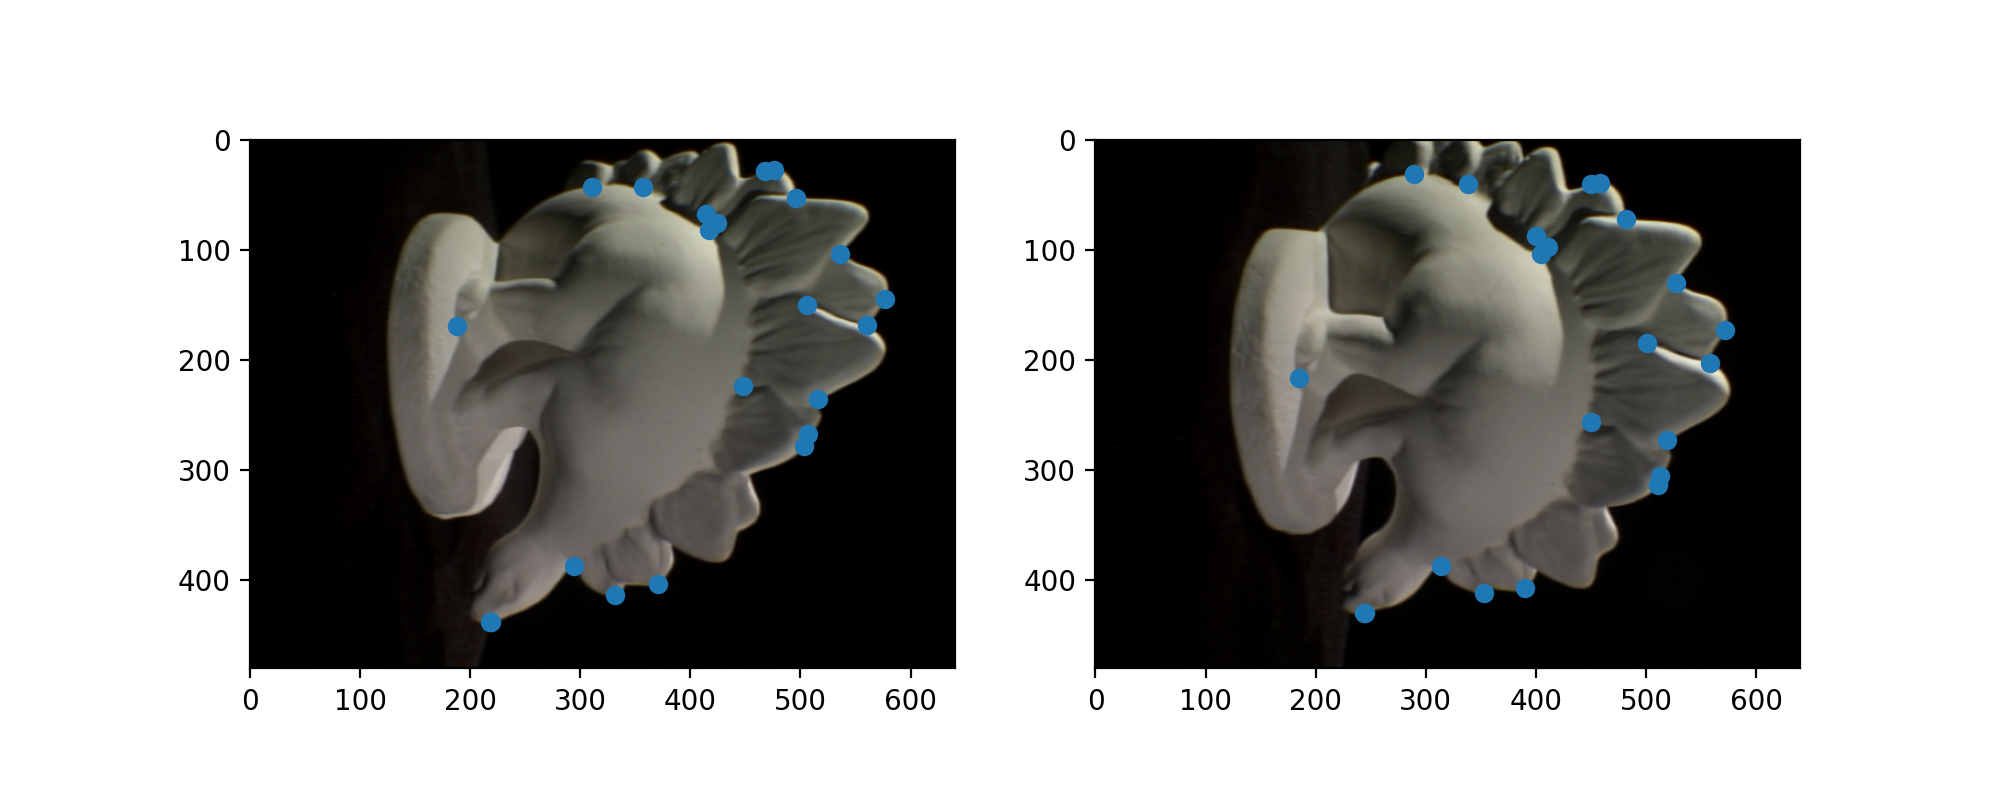

In [63]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)

# Calculate the Fundimental Matrix
i = 0
C1_params = dino_params[i]
C2_params = dino_params[i+1]

K1, R1, T1 = C1_params
K2, R2, T2 = C2_params

F = get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2)

# Get dino images
imL = image.imread(f"dinoSparseRing/dinoSR000{i+1}.png")
imR = image.imread(f"dinoSparseRing/dinoSR000{i+2}.png")

h,w,c = np.shape(imL)

imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

<IPython.core.display.Javascript object>


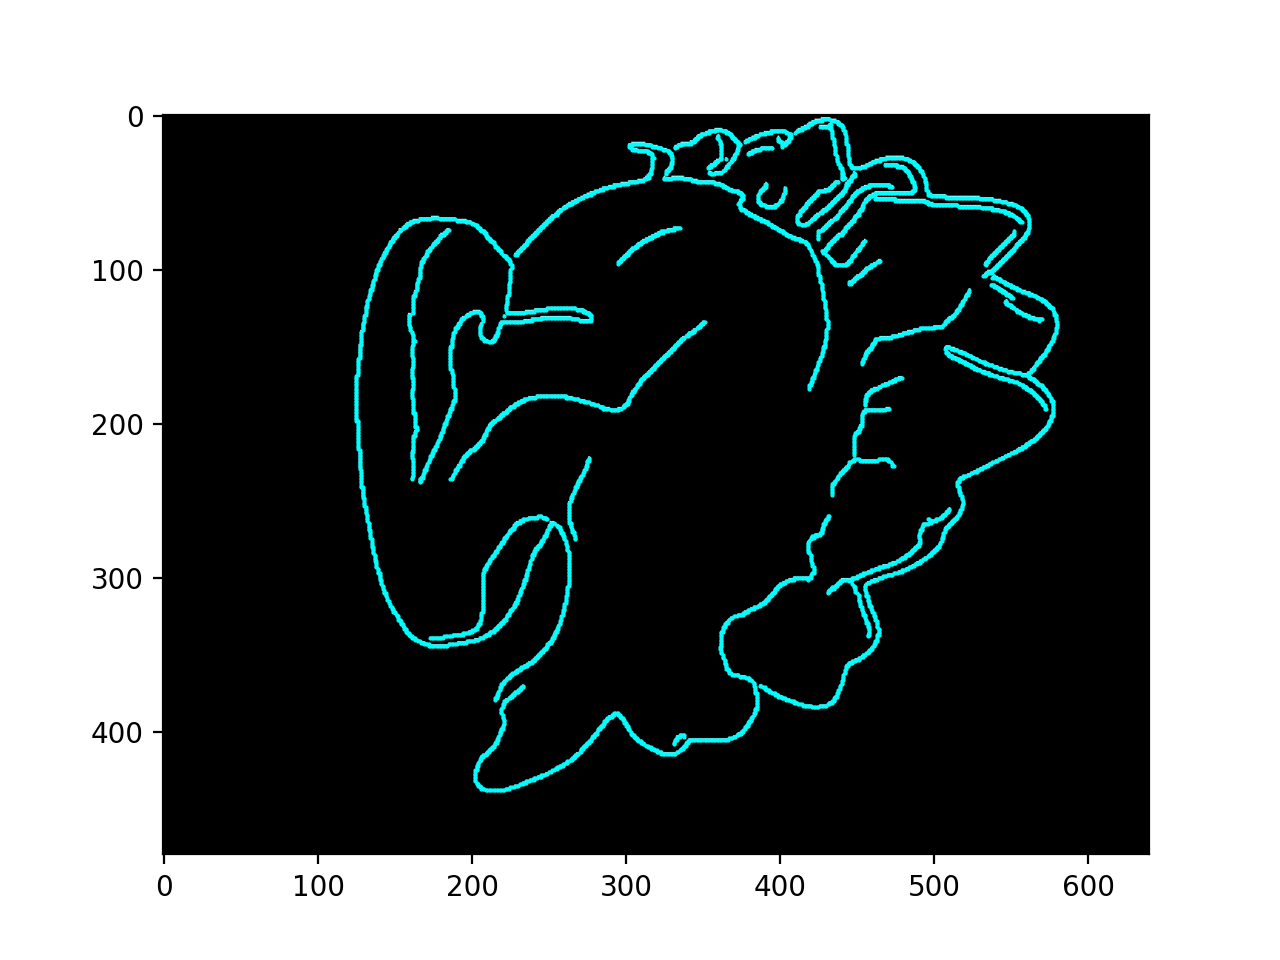

<IPython.core.display.Javascript object>


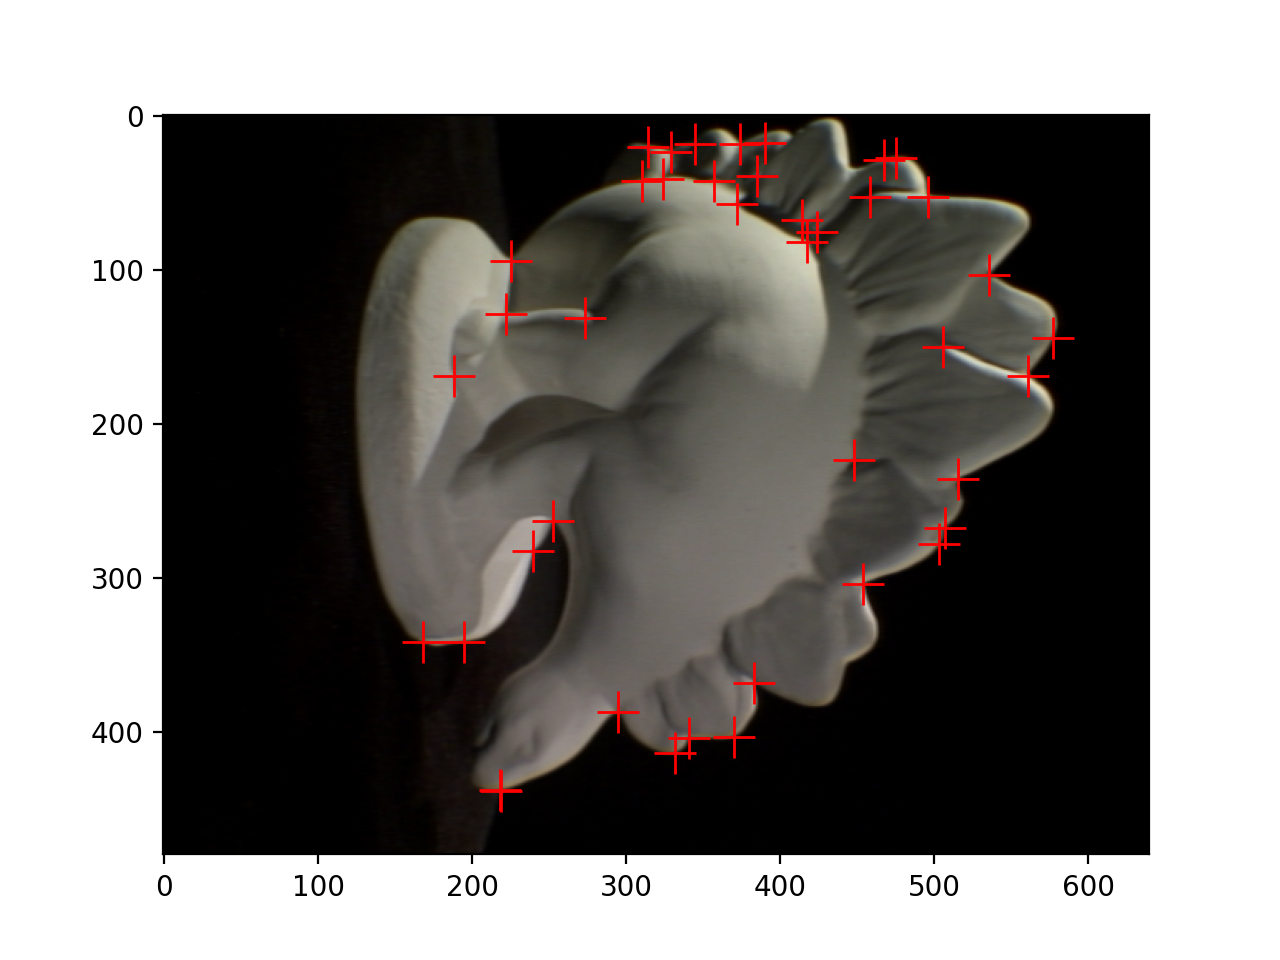

In [64]:
# DELETE LATER
from skimage import feature
from skimage.color import rgb2gray

# Edge detection

imgray = rgb2gray(imL)
can = feature.canny(imgray, 2.0)

# Mesh
y, x = np.where(can)
edge_points = np.append(x[:,None], y[:,None], axis = 1)

fig, ax = plt.subplots()
ax.imshow(can,cmap="gray")
ax.plot(edge_points[:, 0], edge_points[:, 1], color='cyan', marker='o',
        linestyle='None', markersize=0.5)

# Conner detection 
coords = feature.corner_peaks(feature.corner_harris(imgray), min_distance=5, threshold_rel=0.002)
coords_subpix = feature.corner_subpix(imgray, coords, window_size=10)
coords_subpix_cleaned = coords_subpix[~np.isnan(coords_subpix[:,0]),]
coords_subpix_cleaned = np.array([coords_subpix_cleaned[:,1], coords_subpix_cleaned[:,0]]).T

fig, ax = plt.subplots()
ax.imshow(imL, cmap=plt.cm.gray)
# ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#         linestyle='None', markersize=6)
ax.plot(coords_subpix_cleaned[:, 0], coords_subpix_cleaned[:, 1], '+r', markersize=15)
plt.show()

#####

In [160]:
bounding_box_size = 15
num_feature_points = 150
dino_threshold = 0.4

# x1 = sample_on_dino(imL, bounding_box_size, num_feature_points, dino_threshold)
x1 = edge_points[np.random.randint(0,5096, size=num_feature_points),:]
mask_imL = np.where(np.sum(imL, axis = 2) > dino_threshold, 1, 0)
#x1 = coords_subpix_cleaned

In [161]:
x2, u1_list, v1_list, u2_list, v2_list = \
get_match_points_linspace(imL, x1, F, bounding_box_size, epsilon = 0.1, threshold = 0.9)

In [162]:
x1_inbound = np.where(mask_imL[(x1[:,1],x1[:,0])] == 1)
x2_inbound = np.where(mask_imL[(x2[:,1],x2[:,0])] == 1)
inbound = np.intersect1d(x1_inbound[0], x2_inbound[0])
x2a = x2[inbound]
x2_filtered = x2a[np.where(x2a.sum(axis = 1) != -2)]
x1a = x1[inbound]
x1_filtered = x1a[np.where(x2a.sum(axis = 1) != -2)]

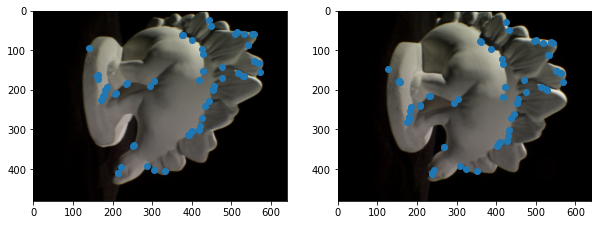

In [163]:
%matplotlib inline
# ------------------------------------ #
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1_filtered[:, 0], x1_filtered[:, 1])
# for i in range(len(x1)): 
#     ax81.plot(u1_list[i], v1_list[i], '-r') 
#     ax81.set_xlim((0, imR.shape[0])) 
#     ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
# ------------------------------------ #
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(x2_filtered[:, 0], x2_filtered[:, 1])
# for i in range(len(x2)): 
#     ax82.plot(u2_list[i], v2_list[i], '-r') 
#     ax82.set_xlim((0, imR.shape[0])) 
#     ax82.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
# ------------------------------------ #
plt.show()

### Triangulation

In [278]:
def linear_triangulation(x1, x2, R, T):
    
    P = np.append(R,T, axis = 1)

    p1 = P[0,:]
    p2 = P[1,:]
    p3 = P[2,:]

    x,y = x1[:,0],x1[:,1]
    x_p,y_p = x2[:,0],x2[:,1]

    a1= p1 - x[:, None] * p3
    a2= p2 - y[:, None] * p3
    a3= p1 - x_p[:, None] * p3
    a4= p2 - y_p[:, None] * p3
    

    X = np.zeros((len(x1), 4))

    for i in range(len(x1)):
        A = np.vstack([a1[i,:],a2[i,:],a3[i,:],a4[i,:]])
        # Descending order
        u,s,v = np.linalg.svd(A)

        X[i,:] = u[-1]

    # Normalize such that (X, Y, Z, 1)
    X = np.divide(X, X[:,3].reshape(len(X),1))

    return X


def linear_triangulation_assignment(x1, x2, R, T):

    P = np.append(R,T, axis = 1)

    p1 = P[0,:]
    p2 = P[1,:]
    p3 = P[2,:]

    x,y = x1[:,0],x1[:,1]
    x_p,y_p = x2[:,0],x2[:,1]

    a1= p1 - x[:, None] * p3
    a2= p2 - y[:, None] * p3
    a3= p1 - x_p[:, None] * p3
    a4= p2 - y_p[:, None] * p3
    
    A_mat = np.concatenate([a1[:,:,None],a2[:,:,None],a3[:,:,None],a4[:,:,None]], axis = 2)
    print(A_mat.shape)
    
    def inv_ls(A, B):
        
        A_tsp = np.transpose(A, (0,2,1))
        NN = np.linalg.pinv(np.matmul(A_tsp, A))
        X = np.matmul(np.matmul(NN, A_tsp), B[:,:,None])
        
        return X.transpose(0,2,1).reshape(-1,3)

    
    X = inv_ls(A_mat[:, :, 0:3], -A_mat[:, :, 3])
    return X




In [279]:
# X = linear_triangulation(x1_filtered, x2_filtered, R1, T1)
X = linear_triangulation_assignment(x1_filtered, x2_filtered, R1, T1)

(63, 4, 4)


In [289]:
# Calculate Camera Centers

P1 = K1 @ np.hstack([R1, T1])
P2 = K2 @ np.hstack([R2, T2])


# Camera center of the first camera
C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
C2 = np.linalg.solve(P2[:, :-1], -P2[:, -1])
# Image Plane coordinate
I1 = np.linalg.solve(P1[:, :-1], -P1[:, -1] + np.array([0,0,1]))
I2 = np.linalg.solve(P2[:, :-1], -P2[:, -1] + np.array([0,0,1]))


C = np.vstack([C1,C2])
I = np.vstack([I1,I2])

In [290]:
-P1[:, -1]# + np.array([1,1,1])

array([-178.71077115,  -37.12732426,   -0.67309782])

<IPython.core.display.Javascript object>


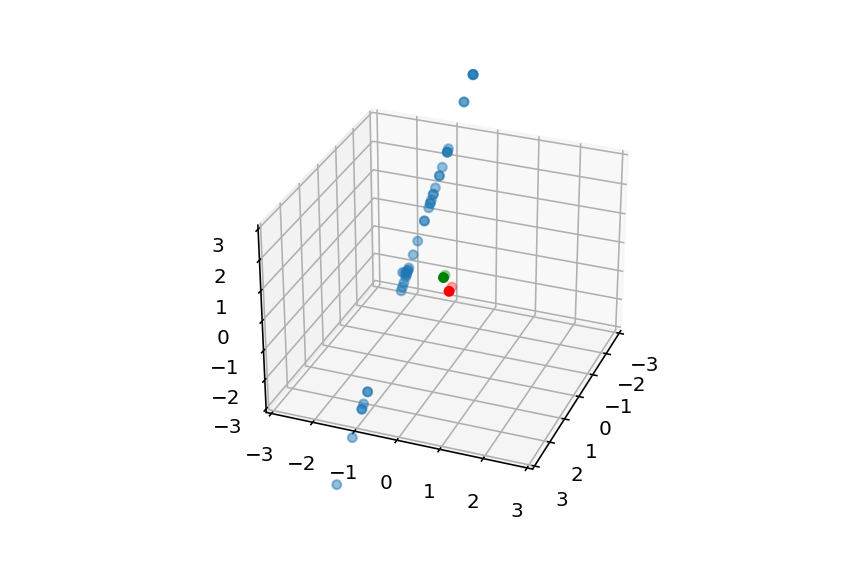

(-3.0, 3.0)

In [292]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
ax.scatter3D(C[:,0],C[:,1], color = "r")
ax.scatter3D(I[:,0],I[:,1], color = "g")
scale = 3
ax.set_xlim([-scale, scale])
ax.set_ylim([-scale, scale])
ax.set_zlim([-scale, scale])

# Garbage from here and below